Neural synthesis & deepdream notes. This is a work in progress. 

This notebook introduces what we'll call here "neural synthesis," the technique of synthesizing images using an iterative process which optimizes the pixels to achieve some desired state in a convolutional neural network. 

The technique dates back to 2013-2014 and has its origins in early attempts to visualize what features were being learned by the different channels in the network (see [Simonyan et al](https://arxiv.org/pdf/1312.6034v2.pdf), and [Mahendran & Vedaldi](https://arxiv.org/pdf/1412.0035v1.pdf)) as well as in trying to identify flaws in networks by synthesizing and feeding them adversarial examples (see [Nguyen et al](https://arxiv.org/pdf/1412.1897v4.pdf), and [Dosovitskiy & Brox](https://arxiv.org/pdf/1506.02753.pdf)). The following is from the original Simonyan paper on visualizing image classification models.

![Simonyan et al](../assets/simonyan-et-al.jpg)

In 2015, the technique became widely known after Google software engineers [Mordvintsev, Olah, and Tyka](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) first used it for ostensibly artistic purposes and introduced several innovations, including optimizing pixels over multiple scales (octaves), improved regularization, and most famously, using real images (photographs, paintings, etc) as input and optimizing their pixels so as to enhance whatever activations the network already sees (hence "hallucinating" or "dreaming"). They nicknamed their work "Deepdream" and released the first publicly available code for running it [in Caffe](https://github.com/google/deepdream/), which led to the technique being widely disseminated on social media, [puppyslugs](https://www.google.de/search?q=puppyslug&safe=off&tbm=isch&tbo=u&source=univ&sa=X&ved=0ahUKEwiT3aOwvtnXAhUHKFAKHXqdCBwQsAQIKQ&biw=960&bih=979) and all. Some highlights of their original work follow, with more found in [this gallery](https://photos.google.com/share/AF1QipPX0SCl7OzWilt9LnuQliattX4OUCj_8EP65_cTVnBmS1jnYgsGQAieQUc1VQWdgQ?key=aVBxWjhwSzg2RjJWLWRuVFBBZEN1d205bUdEMnhB).

![deepdream](https://2.bp.blogspot.com/-17ajatawCW4/VYITTA1NkDI/AAAAAAAAAlM/eZmy5_Uu9TQ/s640/classvis.png)
![deepdream](https://2.bp.blogspot.com/-nxPKPYA8otk/VYIWRcpjZfI/AAAAAAAAAmE/8dSuxLnSNQ4/s640/image-dream-map.png)

A number of creative innovations were introduced by [Mike Tyka](http://www.miketyka.com) including optimizing several channels along pre-arranged masks, and using feedback loops and canvas-warping to generate video.  Some examples of his work follow.

![deepdream](https://1.bp.blogspot.com/-XZ0i0zXOhQk/VYIXdyIL9kI/AAAAAAAAAmQ/UbA6j41w28o/s640/building-dreams.png)

This notebook builds upon the code found in [tensorflow's deepdream example](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream). The first part of this notebook will summarize that notebook, including naive optimization, multiscale generation, and Laplacian normalization. The code from that notebook is lightly modified and found in the the [lapnorm.py](../notebooks/lapnorm.py) script, which is imported. The second part of this notebook builds upon that example by showing how to combine channels and mask their gradients, and warp the canvas. Here is a [gallery of examples](genekogan.com/works/neural-synth/).

To get started, make sure all of the folloing impor statements work without error.

In [26]:
from __future__ import print_function
from io import BytesIO
import math, time, copy, json, os
import glob
from os import listdir
from os.path import isfile, join
from random import random
from io import BytesIO
from enum import Enum
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import scipy.misc
import tensorflow as tf
from lapnorm import *
#import bg file


Number of layers 59
Total number of feature channels: 7548


If you haven't already, download the Inception network, which we will use as our trained convolutional network.

In [4]:
#Grab inception model from online and unzip it (you can skip this step if you've already downloaded the model.
!wget -P ../data/ https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
!unzip ../data/inception5h.zip -d ../data/inception5h/
!rm ../data/inception5h.zip

--2017-11-25 04:36:05--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.176, 2607:f8b0:4006:81a::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘../data/inception5h.zip’

100%[======================================>] 49,937,555  38.7MB/s   in 1.2s   

2017-11-25 04:36:06 (38.7 MB/s) - ‘../data/inception5h.zip’ saved [49937555/49937555]

Archive:  ../data/inception5h.zip
  inflating: ../data/inception5h/imagenet_comp_graph_label_strings.txt  
  inflating: ../data/inception5h/tensorflow_inception_graph.pb  
  inflating: ../data/inception5h/LICENSE  


Let's inspect the network now. The following will give us the name of all the layers in the network, as well as the number of channels they contain. 

In [28]:
for l, layer in enumerate(layers):
    layer = layer.split("/")[1]
    num_channels = T(layer).shape[3]
    print(layer, num_channels)

conv2d0_pre_relu 64
conv2d1_pre_relu 64
conv2d2_pre_relu 192
mixed3a_1x1_pre_relu 64
mixed3a_3x3_bottleneck_pre_relu 96
mixed3a_3x3_pre_relu 128
mixed3a_5x5_bottleneck_pre_relu 16
mixed3a_5x5_pre_relu 32
mixed3a_pool_reduce_pre_relu 32
mixed3b_1x1_pre_relu 128
mixed3b_3x3_bottleneck_pre_relu 128
mixed3b_3x3_pre_relu 192
mixed3b_5x5_bottleneck_pre_relu 32
mixed3b_5x5_pre_relu 96
mixed3b_pool_reduce_pre_relu 64
mixed4a_1x1_pre_relu 192
mixed4a_3x3_bottleneck_pre_relu 96
mixed4a_3x3_pre_relu 204
mixed4a_5x5_bottleneck_pre_relu 16
mixed4a_5x5_pre_relu 48
mixed4a_pool_reduce_pre_relu 64
mixed4b_1x1_pre_relu 160
mixed4b_3x3_bottleneck_pre_relu 112
mixed4b_3x3_pre_relu 224
mixed4b_5x5_bottleneck_pre_relu 24
mixed4b_5x5_pre_relu 64
mixed4b_pool_reduce_pre_relu 64
mixed4c_1x1_pre_relu 128
mixed4c_3x3_bottleneck_pre_relu 128
mixed4c_3x3_pre_relu 256
mixed4c_5x5_bottleneck_pre_relu 24
mixed4c_5x5_pre_relu 64
mixed4c_pool_reduce_pre_relu 64
mixed4d_1x1_pre_relu 112
mixed4d_3x3_bottleneck_pre_relu 

The basic idea is to take any image as input, then iteratively optimize its pixels so as to maximally activate a particular channel (feature extractor) in a trained convolutional network. We reproduce tensorflow's recipe here to read the code in detail. In `render_naive`, we take `img0` as input, then for `iter_n` steps, we calculate the gradient of the pixels with respect to our optimization objective, or in other words, the diff for all of the pixels we must add in order to make the image activate the objective. The objective we pass is a channel in one of the layers of the network, or an entire layer. Declare the function below.

In [29]:
def render_naive(t_obj, img0, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
    return img


Now let's try running it. First, we initialize a 200x200 block of colored noise. We then select the layer `mixed4d_5x5_bottleneck_pre_relu` and the 20th channel in that layer as the objective, and run it through `render_naive` for 40 iterations. 

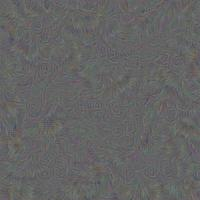

In [30]:
img0 = np.random.uniform(size=(200, 200, 3)) + 100.0
layer = 'mixed4d_5x5_bottleneck_pre_relu'
channel = 20
img1 = render_naive(T(layer)[:,:,:,channel], img0, 40, 1.0)
display_image(img1)

You can try to optimize at different layers or different channels to get a feel for how it looks. The above isn't so interesting yet. One improvement is to use repeated upsampling to effectively detect features at multiple scales (what we call "octaves") of the image. What we do is we start with a smaller image and calculate the gradients for that, going through the procedure like before. Then we upsample it by a particular ratio and calculate the gradients and modify the pixels of the result. We do this several times. 

You can see that `render_multiscale` is similar to `render_naive` except now the addition of the outer "octave" loop which repeatedly upsamples the image using the `resize` function.

In [31]:
def render_multiscale(t_obj, img0, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8        # for different layers and networks
            img += g*step
        print("octave %d/%d"%(octave+1, octave_n))
    clear_output()
    return img


Let's try this on noise first. Note the new variables `octave_n` and `octave_scale` which control the parameters of the scaling. Thanks to tensorflow's patch to do the process on overlapping subrectangles, we don't have to worry about running out of memory. However, making the overall size large will mean the process takes longer to complete.

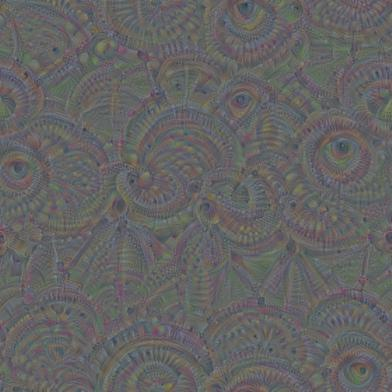

In [32]:
h, w = 200, 200
octave_n = 3
octave_scale = 1.4
iter_n = 30

img0 = np.random.uniform(size=(h, w, 3)) + 100.0

layer = 'mixed4d_5x5_bottleneck_pre_relu'
channel = 25

img1 = render_multiscale(T(layer)[:,:,:,channel], img0, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now load a real image and use that as the starting point. We'll use the kitty image in the assets folder. Here is the original.
<img src="../assets/kitty.jpg" alt="kitty" style="width: 280px;"/>

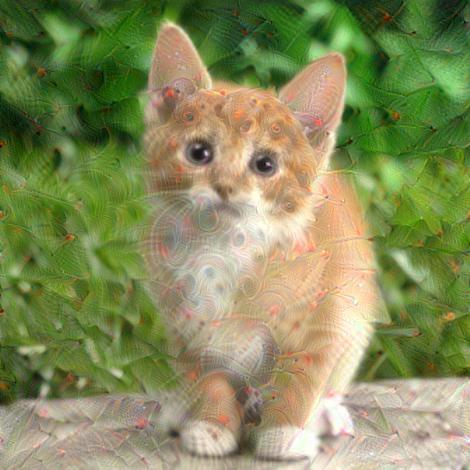

In [33]:
h, w = 240, 240
octave_n = 3
octave_scale = 1.4
iter_n = 30

img0 = load_image('../assets/kitty.jpg', h, w)

layer = 'mixed4d_5x5_bottleneck_pre_relu'
channel = 21

img1 = render_multiscale(T(layer)[:,:,:,channel], img0, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now we introduce Laplacian normalization. The problem is that although we are finding features at multiple scales, it seems to have a lot of unnatural high-frequency noise. We apply a [Laplacian pyramid decomposition](https://en.wikipedia.org/wiki/Pyramid_%28image_processing%29#Laplacian_pyramid) to the image and calculate the pixel gradient at each scale, as before.


In [35]:
def render_lapnorm(t_obj, img0, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    clear_output()
    return img
 

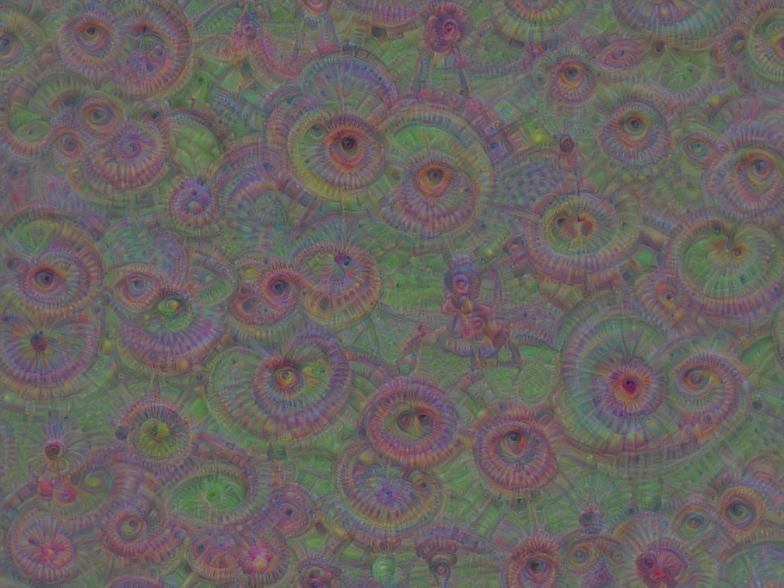

In [36]:
h, w = 300, 400
octave_n = 3
octave_scale = 1.4
iter_n = 10

img0 = np.random.uniform(size=(h, w, 3)) + 100.0

layer = 'mixed4d_5x5_bottleneck_pre_relu'
channel = 25

img1 = render_lapnorm(T(layer)[:,:,:,channel], img0, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now we are going to modify the `render_lapnorm` function in three ways. 

1) Instead of passing just a single objective to be optimized, we can pass several in an array, letting us optimize several channels simultaneously (it must be an array even if it contains just one element).

2) We now also pass in `mask`, which is a numpy array of dimensions (`h`,`w`,`n`) where `h`,`w` is the height and width of the source image `img0` and `n` is equal to the number of objectives in `t_obj`. The mask is like a gate or multiplier of the gradient for each channel. mask[:,:,0] gets multiplied by the gradient of the first objective, mask[:,:,1] by the second and so on. It should contain a float between 0 and 1 (0 to kill the gradient, 1 to let all of it pass).

3) Internally, we use a convenience function `get_mask_sizes` which figures out for us the size of the image and mask at every octave, so we don't have to worry about calculating this ourselves, we just pass in an img and mask of the same size.

In [37]:
def lapnorm_multi(t_obj, img0, mask, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4):
    mask_sizes = get_mask_sizes(mask.shape[0:2], oct_n, oct_s)
    img0 = resize(img0, np.int32(mask_sizes[0])) 
    t_score = [tf.reduce_mean(t) for t in t_obj] # defining the optimization objective
    t_grad = [tf.gradients(t, t_input)[0] for t in t_score] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = mask_sizes[octave] #np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        oct_mask = resize(mask, np.int32(mask_sizes[octave]))
        for i in range(iter_n):
            g_tiled = [lap_norm_func(calc_grad_tiled(img, t)) for t in t_grad]
            for g, gt in enumerate(g_tiled):
                img += gt * step * oct_mask[:,:,g].reshape((oct_mask.shape[0],oct_mask.shape[1],1))
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    clear_output()
    return img

Try first on noise, as before. This time, we pass in two objctives from the same layer (channels 15 and 25) and we create a mask where the top half only lets in the first channel, and the bottom half only lets in the second.

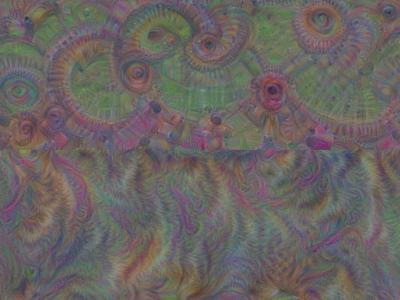

In [38]:
h, w = 300, 400
octave_n = 3
octave_scale = 1.4
iter_n = 10

img0 = np.random.uniform(size=(h, w, 3)) + 100.0

objectives = [T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,25], 
              T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,15]]

# mask
mask = np.zeros((h, w, 2))
mask[:150,:,0] = 1.0
mask[150:,:,1] = 1.0

img1 = lapnorm_multi(objectives, img0, mask, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now the same thing, but we optimize over the kitty instead and pick new channels.

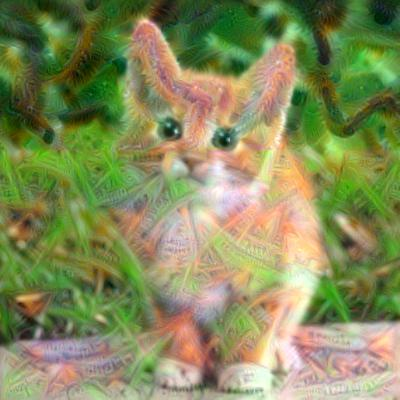

In [40]:
h, w = 400, 400
octave_n = 3
octave_scale = 1.4
iter_n = 10

img0 = load_image('../assets/kitty.jpg', h, w)

objectives = [T('mixed4d_3x3_bottleneck_pre_relu')[:,:,:,125], 
              T('mixed4d_3x3_bottleneck_pre_relu')[:,:,:,59]]

# mask
mask = np.zeros((h, w, 2))
mask[:150,:,0] = 1.0
mask[150:,:,1] = 1.0

img1 = lapnorm_multi(objectives, img0, mask, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Let's make a more complicated mask. ... 

mask


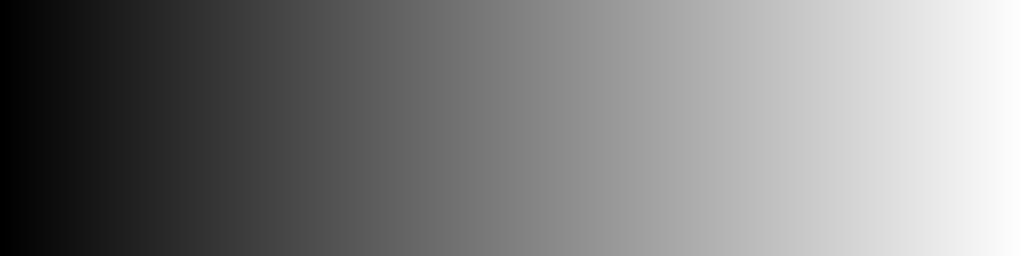

image


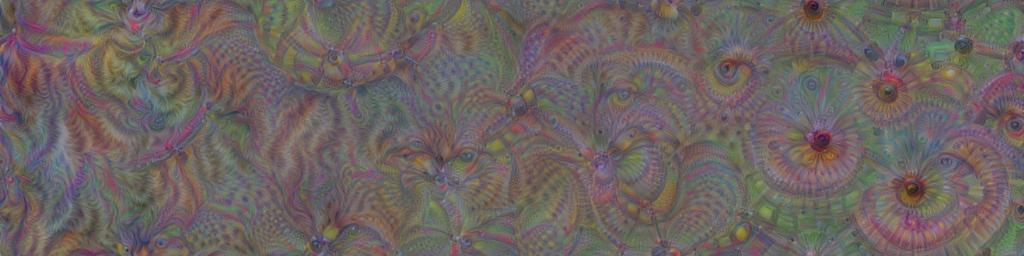

In [41]:
h, w = 256, 1024

img0 = np.random.uniform(size=(h, w, 3)) + 100.0

octave_n = 3
octave_scale = 1.4
objectives = [T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,25], 
              T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,15]]

mask = np.zeros((h, w,2))
mask[:,:,0] = np.linspace(0,1,w)
mask[:,:,1] = np.linspace(1,0,w)

img1 = lapnorm_multi(objectives, img0, mask, iter_n=20, step=1.0, oct_n=3, oct_s=1.4, lap_n=4)

print("mask")
display_image(255*mask[:,:,0])
print("image")
display_image(img1)
